In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn-notebook")

# Solution to Exercise 3: Traveltime and regularization in two dimensions (Dec. 2, 2021)
---

Assume straight ray paths between transmitter and receiver on a two-dimensional
model space. The travel time $t$ of the $q$-th ray path can be expressed as:

$$ t_q = \int_{L_q} \frac{1}{v(l)} dl \approx \sum_i s_i l_i, $$

where $v$ is the velocity and $L_q$ the total travel path of this ray, $l_i$
are the individual ray paths in each cell, and $s_i$ are the discrete and
piecewise constant slowness values. To do a forward computation, the travel
times through each discrete cell can be determined geometrically and formulated
in matrix notation as:

$$ \mathbf{t} = \mathbf{G} \mathbf{s}. $$

Here, the cumulated travel times of all rays form the vector $\mathbf{t}$, the
slowness values of all cells are located in $\mathbf{s}$ and the ray paths of every
ray form the matrix $\mathbf{G}$.  The matrix $\mathbf{G}$ contains one row per ray and
one column per model cell. Accordingly, measured travel times $\mathbf{t}$ are
associated with the data vector $\mathbf{d}$, and slowness values $\mathbf{s}$ are
associated with the model parameters $\mathbf{m}$. The corresponding geometry is displayed in the figure below.

<img src="http://www2.geo.uni-bonn.de/~wagner/2dsimple.png" style="width:40%">

*[Figure](http://www2.geo.uni-bonn.de/~wagner/2dsimple.png): Measurement setup of a simple travel time tomography measurement. Green lines indicate ray paths of the individual measurements (with the label dX being the $X^{th}$ measurement, located at the end of the path). Parameter numbers are given in the lower-right corner of each cell (zero indexed).* 

### a) Solve the inverse problem, i.e. estimate the slowness distribution based on the traveltimes. Do you need regularization to solve the inverse problem? Construct the first-order smoothing matrix.

Test if your smoothing matrix is correct by multiplying it with a homogeneous models ([`np.ones`](https://numpy.org/doc/stable/reference/generated/numpy.ones.html?highlight=ones#numpy.ones)) and for comparison with random models ([`np.random.randn`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.randn.html?highlight=randn#numpy.random.randn)). What is the model norm ([`np.linalg.norm`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html?highlight=linalg%20norm#numpy.linalg.norm)) $||\mathbf{W_m m_\text{homogeneous}}||_2$? What should it be?

In [2]:
Wm = np.zeros((40,25))
a = -np.eye(4, 5) + np.eye(4, 5, k=1)
b = -np.eye(20, 25) + np.eye(20, 25, k=5)
Wm[20:] = b
for i in range(5):
    j = i * 4
    Wm[j:j + 4, j + i:j + 5 + i] = a

In [3]:
plt.matshow(Wm, cmap="PiYG")
plt.colorbar()

In [4]:
print("Random model:", np.linalg.norm(Wm @ np.random.randn(25)))
print("Homogeneous model:", np.linalg.norm(Wm @ np.ones(25)))

Random model: 10.642993265231786
Homogeneous model: 0.0


### b) Construct the generalized inverse $\mathbf{G}^{-g}$ first 5 measurements only.

Estimate the model parameters for both setups given the data vector from the previous exercise. 

**Plotting hint**:

You can visualize the true and estimated model on the model grid.

The model vector is always used as a vector in the calculations (also in 2D and 3D). In this 2D example, we can make use of the reshape method. So assume we want to visualize the number of the model parameters, we can do this:

``` python
import numpy as np
import matplotlib.pyplot as plt

model1d = np.arange(25) # Just the model indices
model2d = model1d.reshape((5, 5))[::-1] # rearrange to 5,5 and flip upside down

# Visualize the model as a colored 2D matrix
fig, ax = plt.subplots()
im = ax.imshow(model2d, interpolation='none', extent=[0, 5, 0, 5])
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Model parameter numbering")
```

We start by defining a helper function whichs plots the model vectors as a colored 2D matrix together with the ray paths. This is an extension of the code snippet above.

In [5]:
# formulate G with 9 measurements and 25 model parameters (b)
Gf = np.zeros((9, 25))

a = 1 # horizontal distance through cell
b = np.sqrt(2) # diagonal distance through cell

Gf[0, 4] = b
Gf[1, 3] = b
Gf[1, 9] = b
Gf[2, 5:10] = a
Gf[3, 20:25] = a
Gf[4, np.arange(2,23,5)] = a
Gf[5, np.arange(0,25,6)] = b
Gf[6, 15:20] = a
Gf[7, 10:15] = a
Gf[8, 0:5] = a

# small G (first five measurements, task a)
Gs = Gf[:5]

m = [5, 1,  1,  1,  5,  1,  5,  1,  5,  1,  1, 1,  5,  1,  1,  1,  5,  1, 5,  1,  5,  1,  1,  1,  5]
d = np.array([7.07106781, 2.82842712,  13, 13, 9, 35.35533906, 13, 9, 13])

In [6]:
def plot_model(model_raw=None, nr_data=5, label="Slowness (s/m)", cmap="viridis"):
    """This function plots and annotates the 5x5 model."""
    # define measurements using start and end coordinates
    measurements = [
        # x0, y0, x1, y1
        (4, 0, 5, 1),
        (3, 0, 5, 2),
        (0, 1.5, 5, 1.5),
        (0, 4.5, 5, 4.5),
        (2.5, 0, 2.5, 5),
        (0, 0, 5, 5),
        (0, 3.5, 5, 3.5),
        (0, 2.5, 5, 2.5),
        (0, 0.5, 5, 0.5),
    ]

    if model_raw is None:
        model_raw = np.zeros(25)
        label = None
    model = np.asarray(model_raw).reshape((5, 5))[::-1]
    
    fig, ax = plt.subplots(dpi=110)
    im = ax.imshow(model, interpolation='none', extent=[0, 5, 0, 5],
                   cmap=cmap)
    if label is not None:
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label(label)

    for nr, m in enumerate(measurements[0:nr_data]):
        ax.annotate(text='', xy=(m[0], m[1]), xytext=(m[2], m[3]), arrowprops=dict(arrowstyle='<-', lw=2, color="w"))
        ax.annotate('$d_{0}$'.format(nr), xy=(m[2], m[3]), color="k",
                    fontsize=16, fontweight="bold")

    # show numbers of each grid cell
    index = 0
    for y in range(0, 5):
        for x in range(0, 5):
            ax.annotate('# {0}'.format(index),
                        xy=(x + 0.6, y + 0.1), color='w',
                        fontsize=10.0, alpha=0.5)
            index += 1

    ax.grid()
    fig.tight_layout()

In [7]:
def generalized_inverse(G, beta=1e-4, smoothing=False):
    """Return generalized inverse for a given G with damping."""
    if smoothing:
        WTW = Wm.T @ Wm
    else:
        WTW = np.eye(G.shape[1])
    Ginv = np.linalg.inv(G.T @ G + beta * WTW) @ G.T
    return Ginv

In [8]:
smooth = True
m_est_s = generalized_inverse(Gs, smoothing=smooth) @ d[:5]
plot_model(m_est_s)

### c) Compare the model estimate using **damping and smoothing** to the true model in terms of absolute relative deviation. **Which model parameter is closest to the true model?** (You don't need to take a look at all parameters manually if you use the [argmin](https://numpy.org/doc/stable/reference/generated/numpy.argmin.html?highlight=argmin#numpy.argmin) function.)

In [9]:
smooth = True
m_est_f = generalized_inverse(Gf, smoothing=smooth) @ d
diff_f = np.abs((m_est_f - m)/m * 100)

In [10]:
plot_model(diff_f, nr_data=5, label="Percentage difference")
print("Closest to the true model is parameter no.", np.argmin(diff_f))

Closest to the true model is parameter no. 4


Closest to the true model is parameter no. 4


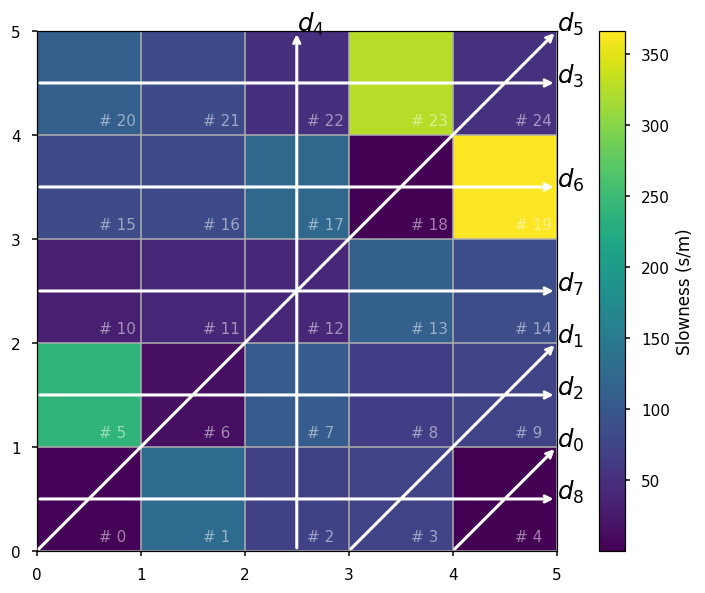

In [11]:
m_est_s = generalized_inverse(Gs, smoothing=smooth) @ d[:5]
diff_s = np.abs((m_est_s - m)/m * 100)

plot_model(diff_f, nr_data=9)
print("Closest to the true model is parameter no.", np.argmin(diff_s))

### d) Calculate the coverage (or cumulative sensitivity), i.e. the sum of all ray path segments per model cell for the small and the full setup. Visualize the coverage on the model grid. Which cell has the highest coverage? Is it the same cell/model parameter, which is closest to the true model?

#### For 5 measurements

Highest sensitivity is in cell no. 9


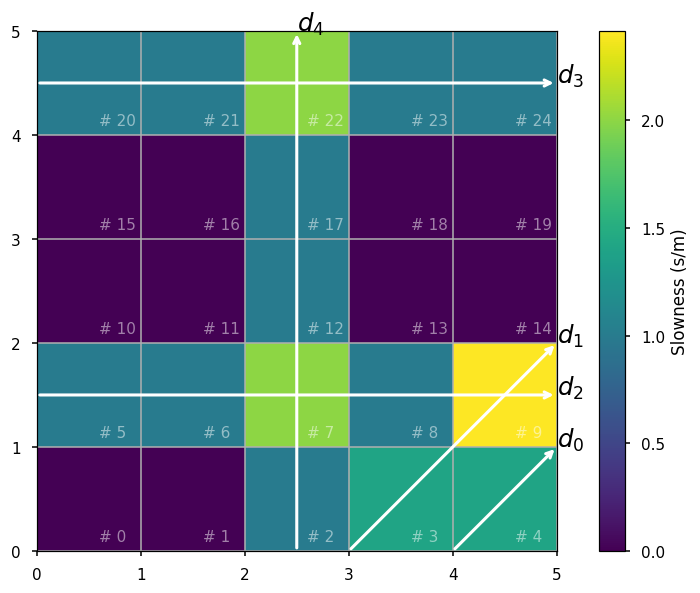

In [12]:
sens_small = np.sum(Gs, axis=0)
print("Highest sensitivity is in cell no.", np.argmax(sens_small))
plot_model(sens_small, nr_data=5)

#### For all 9 measurements

Highest sensitivity is in cell no. 12


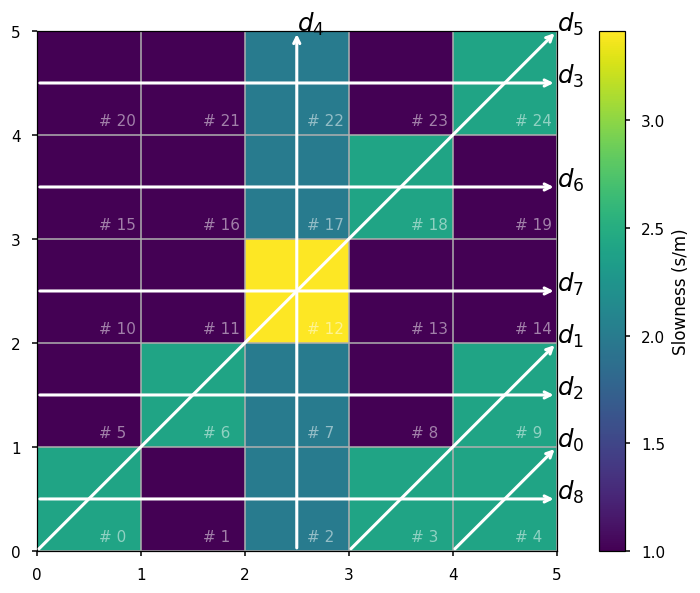

In [13]:
sens_full = np.sum(Gf, axis=0)
print("Highest sensitivity is in cell no.", np.argmax(sens_full))
plot_model(sens_full, nr_data=9)

#### e) Calculate the model resolution for both setups. Visualize the diagonal of the resolution matrix on the model grid. Which cell has the highest resolution? Is it the same cell/model parameter, which is closest to the true model?

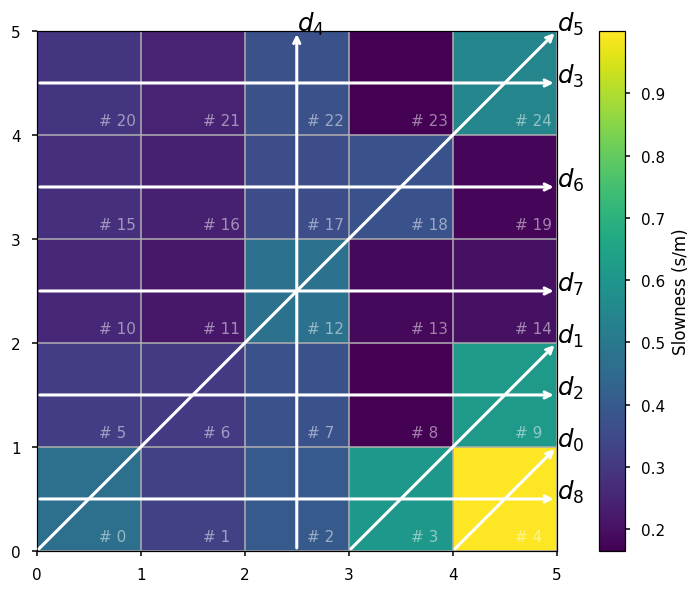

In [14]:
R = generalized_inverse(Gf, smoothing=smooth) @ Gf
r_diag = np.diag(R)
plot_model(r_diag, nr_data=9)

<div class="alert alert-block alert-info" style="background-color: white; border: 2px solid; padding: 10px">
    <b><i class="fa fa-info-circle" aria-hidden="true"></i>&nbsp; Important</b><br>
    <p style="color: black">
        The cell with the highest sensitivity (#12) is not the best resolved cell, i.e. closest to the true model, but the cell with the highest  resolution (#4) is. Hence, the model resolution, although computationally more expensive for larger 3D models, is the more powerful tool for image appraisal and experimental design, as it also accounts for the linear (in)dependency of the measurements.
    </p>
<div>